In [1]:
# https://www.kaggle.com/alexeykupershtokh/concat-dataframes
# Creating Concatinated Dataset with both train and test
import os
import gc
import random
from pathlib import Path
import multiprocessing
from pprint import pprint, pformat

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import fastai
from fastai import metrics
from fastai.tabular import FillMissing, Categorify, Normalize, DatasetType
from fastai.tabular import TabularDataBunch, tabular_learner, TabularList, load_learner
print(fastai.__version__)

seed = 42
random.seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

INPUT = Path('/kaggle/input/ieee-fraud-detection')

1.0.57


In [2]:
def basic_mem_reduction(df):
    """Casts each column to the smallest dtype it can without throwing an error."""
    start_mem = df.memory_usage(deep=True).sum() / 1024 ** 2
    df = (df.pipe(all_float_to_int)
          .pipe(downcast_all, "float")
          .pipe(downcast_all, "integer")
          .pipe(downcast_all, target_type="unsigned", inital_type="integer"))
    end_mem = df.memory_usage(deep=True).sum() / 1024 ** 2
    diff = end_mem - start_mem
    pct = int(diff/start_mem * 100)
    print(f"Saved {diff}Mb of Memory: {pct}%")
    return df


def float_to_int(series):
    try:
        int_ser = series.astype(int)
        if (series == int_ser).all():
            return int_ser
        else:
            return series
    except (ValueError, AssertionError):
        return series


def all_float_to_int(df):
    func = float_to_int
    condition = lambda x: list(x.select_dtypes(include=["float"]).columns)
    return multi_assign(df, func, condition)


def multi_assign(df, func, condition):
    """
    Applies function <func> to every column in <df> which satisfies <condition>
    """
    return df.assign(**{col: func(df[col]) for col in condition(df)})


def downcast_all(df, target_type, inital_type=None):
    """
    :param df: target dataframe
    :param target_type: 'float', 'integer' or 'unisgned'
    :param inital_type: same as target_type
    :return: downcasted dataframe
    """
    if inital_type is None:
        inital_type = target_type
    transform = lambda x: pd.to_numeric(x, downcast=target_type)
    condition = lambda x: list(x.select_dtypes(include=[inital_type]).columns)
    return multi_assign(df, transform, condition)


In [3]:
nrows = None

train_identity = pd.read_csv(INPUT / 'train_identity.csv', nrows=nrows)
train_identity = basic_mem_reduction(train_identity)
train_transaction = pd.read_csv(INPUT / 'train_transaction.csv', nrows=nrows)
train_transaction = basic_mem_reduction(train_transaction)
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left', left_index=True, right_index=True)

del train_identity, train_transaction
gc.collect()

test_identity = pd.read_csv(INPUT / 'test_identity.csv', nrows=nrows)
test_identity = basic_mem_reduction(test_identity)
test_transaction = pd.read_csv(INPUT / 'test_transaction.csv', nrows=nrows)
test_transaction = basic_mem_reduction(test_transaction)
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left', left_index=True, right_index=True)

del test_identity, test_transaction
gc.collect()

Saved -13.617579460144043Mb of Memory: -8%
Saved -875.7493019104004Mb of Memory: -41%
Saved -13.39797306060791Mb of Memory: -8%
Saved -778.4645090103149Mb of Memory: -42%


0

In [4]:
train.to_pickle('train.pkl')
test.to_pickle('test.pkl')

# TEST WITH FASTAI
I had issues with the cleaned data not working in fastai properly because of weird things with indexes and whatnot. If the lr_finder works properly, that's a passing test.

In [5]:
pct = 0.2
indxs = list(train.index)
wanted_num = int(len(indxs) * pct)
valid_idx = [random.randrange(len(indxs)) for x in range(wanted_num)]
print(f"Getting {pct*100}% of indexes: {wanted_num}/{len(indxs)}")

Getting 20.0% of indexes: 118108/590540


In [6]:
def get_cat_names(df):
    cards = [f"card{i}" for i in range(1, 7)]
    matches = [f"M{i}" for i in range(1, 10)]
    trx_cats = ["ProductCD", "addr1", "addr2", "P_emaildomain", "R_emaildomain", *cards, *matches]
    ids = [f"id_{i}" for i in range(12, 39)]
    id_cats = ["DeviceType", "DeviceInfo", *ids]
    cat_names = trx_cats + id_cats
    cat_names = [x for x in cat_names if x in df.columns]
    cont_names = [x for x in df.columns if x not in cat_names]
    return cat_names, cont_names

In [7]:
cat_names, cont_names = get_cat_names(train)

In [8]:
for col in train.columns:
    type_ = str(train[col].dtype)
    if col in cat_names:
        train[col] = train[col].astype('category')
        continue
    if 'float' not in type_ and 'int' not in type_:
        continue
train['isFraud'] = train['isFraud'].astype('category')

In [9]:
cat_names, cont_names = get_cat_names(train)
procs = [FillMissing, Categorify, Normalize]
data = TabularDataBunch.from_df('/models', train, 'isFraud', valid_idx=valid_idx, procs=procs, cat_names=cat_names)

In [10]:
learner = tabular_learner(data, layers=[400, 100], emb_drop=0.2, ps=[0.2, 0.2], metrics=[metrics.AUROC()])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


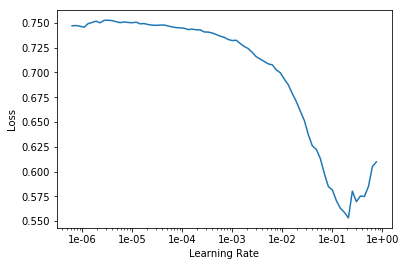

In [11]:
learner.lr_find()
learner.recorder.plot()

In [12]:
learner.validate()

[0.6946504, tensor(0.3292)]